In [2]:
import keras
import pandas as pd
import numpy as np 
import matplotlib as plt

Using TensorFlow backend.


# Here, we can import our data

## This time, "Rented" houses are dropped. Any unknown year is dropped too. 
### Currently, a hard price < 50k cutoff is applied. however, it should be noted that a modern 30 million dollar house may lease for a high amount, so this algorithm must be improved

In [13]:
#dataIN = pd.read_excel('/home/max/resd_data.xlsx')
dataIN = pd.read_excel('/Volumes/Library/Download Bin/resd_data.xlsx')

#filling (Nan -> 0)
data = dataIN.fillna(0)

#no leasing.. requires some feature engineering
data = pd.read_excel('/Volumes/Library/Download Bin/resd_data.xlsx')
data = data.fillna(0)
data = data[data.ListPrice >= 50000]

#filtered Dataset where Year is missing
#YearHasNoZeros = data = data[data.YearBuilt != 0]
data = data[data.YearBuilt != 0]

#filtered dataset where NO zeros exist whatsoever!
#NoZeros = data.loc[~(data==0).any(axis=1)]

#Fix the index because ROWS were dropped
data = data.reset_index(drop=True)


total_input = np.array([[data.SquareFootageStructure],[data.LotSquareFootage],[data.YearBuilt],[data.Bedrooms],[data.BathsTotal],[data.field_StoriesTotal],[data.field_PostalCode]])
#total_input = np.array([[data.SquareFootageStructure],[data.LotSquareFootage],[data.YearBuilt],[data.Bedrooms],[data.BathsTotal],[data.field_StoriesTotal]])
total_label = np.array([data.ListPrice])



array([[  649900.,  2599000.,  2599999., ...,   228500., 51000000.,
          399990.]])

# Next, data is formatted to proper tensors
## We need train and test data, as well as train and test labels
## Size and dimensions must always agree. Labels should be (1xLength)

In [24]:
#Prepwork
END = len(np.transpose(total_input))
END_IN = END - 1000 #Here is where you specify your reserved test data

#slicing
total_input = np.array([[data.SquareFootageStructure],[data.LotSquareFootage],[data.YearBuilt],[data.Bedrooms],[data.BathsTotal],[data.field_StoriesTotal],[data.field_PostalCode]])
total_label = np.array([data.ListPrice])

#dicing 
train_input = total_input[:,0,0:END_IN]
test_input = total_input[:,0,END_IN:END]
train_label = total_label[:,0:END_IN]
test_label = total_label[:,END_IN:END]

#rotation
train_data = np.transpose(train_input)
test_data = np.transpose(test_input)
train_targets = np.transpose(train_label)
test_targets = np.transpose(test_label)

#verification 
print(train_data.shape)
print(test_data.shape)
print(train_targets.shape)
print(test_targets.shape)

mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std
test_data -= mean
test_data /= std

train_max = train_targets.max()
train_targets = train_targets / train_max

test_max = test_targets.max()
test_targets = test_targets / test_max

(6736, 7)
(1000, 7)
(6736, 1)
(1000, 1)


# Build the model here
## Layers are chosen within the function
## This model follows that in the book, Page 86

In [25]:
from keras import models
from keras import layers

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                            input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

# The model is fit in this section
## K-fold validation is applied, by following the book's example

In [26]:
k=2
num_val_samples = len(train_data) // k
num_epochs = 8 #100
all_scores = []
all_mae_histories = []

for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples] 
    
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate( [train_data[:i * num_val_samples],
    train_data[(i + 1) * num_val_samples:]], axis=0)
    
    partial_train_targets = np.concatenate( [train_targets[:i * num_val_samples],
    train_targets[(i + 1) * num_val_samples:]], axis=0)
    
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
              validation_data=(val_data, val_targets),
              epochs=num_epochs, batch_size=1, verbose=1)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

('processing fold #', 0)
Train on 3368 samples, validate on 3368 samples
Epoch 1/8
3368/3368 [==============================] - 9s 3ms/step - loss: 0.0036 - mean_absolute_error: 0.0310 - val_loss: 0.0038 - val_mean_absolute_error: 0.0219
Epoch 2/8
3368/3368 [==============================] - 9s 3ms/step - loss: 0.0013 - mean_absolute_error: 0.0153 - val_loss: 0.0029 - val_mean_absolute_error: 0.0136
Epoch 3/8
3368/3368 [==============================] - 9s 3ms/step - loss: 0.0012 - mean_absolute_error: 0.0129 - val_loss: 0.0014 - val_mean_absolute_error: 0.0119
Epoch 4/8
3368/3368 [==============================] - 9s 3ms/step - loss: 0.0013 - mean_absolute_error: 0.0128 - val_loss: 0.0018 - val_mean_absolute_error: 0.0141
Epoch 5/8
3368/3368 [==============================] - 9s 3ms/step - loss: 0.0011 - mean_absolute_error: 0.0127 - val_loss: 0.0017 - val_mean_absolute_error: 0.0119
Epoch 6/8
3368/3368 [==============================] - 9s 3ms/step - loss: 0.0011 - mean_absolute_erro

# Verification of scores, as done in book

In [27]:
all_scores
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]
average_mae_history

[0.026436376481913854,
 0.01558998783566019,
 0.012807805819792652,
 0.012796243700677765,
 0.01304363641868063,
 0.011983073126319924,
 0.01340866512296812,
 0.011797928347831898]

# Visualize how the score changes by epoch

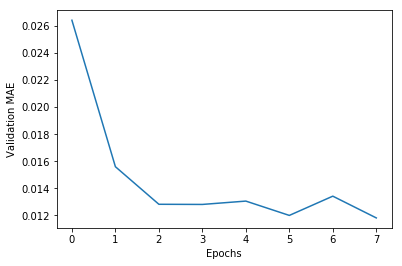

In [29]:
import matplotlib.pyplot as plt
import matplotlib.axes as axes
plt.plot(average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')

plt.show()

# Compare test and training data visually
## Select a slice of both the input data and the input label
## Create a prediction vector using the stored model
## Plot the prediction model with the input labels
## The closer the lines overlap, the better the prediction 

(0, 7187502.500000001)

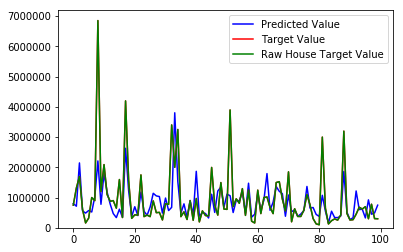

In [33]:
#Discrete Value Input
x=[[4000],[6000],[1995],[4],[4],[1],[90069]]
#x=[[1549],[5825],[1974],[3],[2],[1],[92624]]
x = np.transpose(x)

#Selected Range Input
A=1000
B=1100 
C = B - A
x = train_data[A:B,:]
y = train_targets[A:B]
#test_targets 
y_pred = model.predict(x)
y_label = np.transpose(train_label)[A:B]
#plt.plot(t, a, 'r') # plotting t, a separately 
#plt.plot(t, b, 'b') # plotting t, b separately 


plt.plot(y_pred*train_max,'b',label='Predicted Value')
plt.plot(y*train_max,'r',label='Target Value')
plt.plot(y_label,'g',label='Raw House Target Value')
plt.legend()
plt.ylim(bottom=0)

In [38]:
np.argwhere(y_label <= 50000)

array([], shape=(0, 2), dtype=int64)

# Observe entire prediction of test data

Text(0,0.5,'Cost')

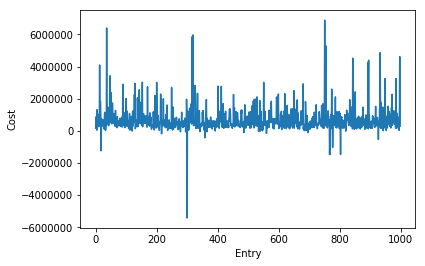

In [9]:
price = model.predict(test_data)
price = price * train_max

plt.plot(price)
plt.xlabel('Entry')
plt.ylabel('Cost')